In [74]:
# Import necessary libraries
import cobra
import glob
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import os
import pandas as pd
import random

from cobra.medium import minimal_medium

input_path = '/mnt/Local_Disk_1/Hospital_Microbiome/Data/Output_data/network_files/'
model_path = '/mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/Models/'
output_path = '/mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/'
sample_path = '/mnt/Local_Disk_1/Hospital_Microbiome/Data/Output_data/phyloseq_source/'

In [ ]:
# Load all the models
os.chdir(model_path)

# Create an empty DataFrame to store the results
model_info = pd.DataFrame(columns=["Model", "Predicted growth rate", "Number of Genes", "Number of Metabolites", "Number of Reactions"])

# Loop through each SBML file
for models in os.listdir(model_path):
    if models.endswith(".xml"): 
        model = cobra.io.read_sbml_model(models) 
        solution = model.optimize()
        model_info.loc[len(model_info)] = { 
            "Model": models, 
            "Predicted growth rate": solution.objective_value,
            "Number of Genes": len(model.genes),
            "Number of Metabolites": len(model.metabolites),
            "Number of Reactions": len(model.reactions)
        }

model_info.set_index('Model', inplace=True)

# Save the results
model_info.to_csv(output_path + 'model_info.csv', sep = ",", index = True)

model_info

In [121]:
# Generating smetana scores for the communities
environments = ["Hospital", "MetaSUB", "Office"]

# Loading nodes/ interactions informations
nodes_info, edges_info = {}, {}

for env in environments:
    net_edges = pd.read_csv(input_path + env + '_edges.tsv', sep = ",")
    nodes = list(set((list(net_edges['v1']) + list(net_edges['v2']))))
    nodes_info[env] = nodes
    edges_info[env] = net_edges

# Loading abundance information
sample_info = {}

for env in environments:
    sample_info[env] = pd.read_csv(sample_path + env + '_filtered_data.csv', sep = ",")
    sample_info[env].set_index('Species', inplace = True)

sample_info['Hospital'].head()
#edges_info['Hospital'].head()

MEE001   MEE002  MEE003  MEE004  MEE005  MEE006  \
Species                                                                        
Abiotrophia defectiva       0.00000  0.00317     0.0     0.0     0.0     0.0   
Achromobacter xylosoxidans  0.00000  0.00000     0.0     0.0     0.0     0.0   
Acinetobacter baumannii     0.00258  0.00000     0.0     0.0     0.0     0.0   
Acinetobacter johnsonii     0.00000  0.00000     0.0     0.0     0.0     0.0   
Acinetobacter junii         0.00281  0.01040     0.0     0.0     0.0     0.0   

                            MEE007  MEE008   MEE009  MEE010  ...   WEE376  \
Species                                                      ...            
Abiotrophia defectiva          0.0     0.0  0.00000     0.0  ...  0.00000   
Achromobacter xylosoxidans     0.0     0.0  0.00215     0.0  ...  0.00000   
Acinetobacter baumannii        0.0     0.0  0.00000     0.0  ...  0.01955   
Acinetobacter johnsonii        0.0     0.0  0.00000     0.0  ...  0.00000   
Acinetobacter junii            0.0     0.0  0.00000     0.0  ...  0.00193   

                             WEE377   WEE378   WEE379  WEE380   WEE381  \
Species                                                                  
Abiotrophia defectiva       0.00000  0.17724  0.00000     0.0  0.00578   
Achromobacter xylosoxidans  0.00000  0.00000  0.00000     0.0  0.00000   
Acinetobacter baumannii     0.00427  0.01885  0.00785     0.0  0.02886   
Acinetobacter johnsonii     0.00000  0.00000  0.00255     0.0  0.00000   
Acinetobacter junii         0.00000  0.00468  0.00409     0.0  0.00300   

                             WEE382   WEE384   WEE385   WEE386  
Species                                                         
Abiotrophia defectiva       0.00000  0.00129  0.00777  0.00518  
Achromobacter xylosoxidans  0.00000  0.00000  0.00000  0.00000  
Acinetobacter baumannii     0.00532  0.00551  0.00291  0.01378  
Acinetobacter johnsonii     0.01293  0.00204  0.00000  0.00000  
Acinetobacter junii         0.00311  0.00556  0.00000  0.00400  

[5 rows x 428 columns]

In [26]:
# Saving network information from the edge file to the networkx graph
network_info = {}

for env in environments:
    G = nx.Graph()

    # Add edges
    for _, row in edges_info[env].iterrows():
        G.add_edge(row['v1'], row['v2'], weight = row['Weight'])
    
    network_info[env] = G
    
# Network details
network_data = pd.DataFrame(columns=["Network", "Number of Nodes", 
                                    "Number of Edges"])

for graph_name, graph in network_info.items():

    # Extract network information
    num_nodes = len(graph.nodes)
    num_edges = len(graph.edges)

    # Create a DataFrame to store the results
    network_data.loc[len(network_data)] = [graph_name, num_nodes, num_edges]

network_data.set_index('Network', inplace=True)
network_data

Number of Nodes  Number of Edges
Network                                   
Hospital               83              506
MetaSUB                43               97
Office                 14               30

In [53]:
# Set a seed for reproducibility
random.seed(42)

# Generate environment-specific communities
def generate_community(graph, env="Hospital", num_nodes=5, num_subgraphs=10, sample_info=sample_info):
    community_df = {"community id": [], "organism id": []}
    communities_generated = 0

    while communities_generated < num_subgraphs:
        node_list = list(graph.nodes())
        nodes = random.sample(node_list, num_nodes)  
        subgraph = graph.subgraph(nodes)  

        if nx.is_connected(subgraph):  
            community_id = f"{env}_{num_nodes}_{num_subgraphs}_{communities_generated+1}" 
            organism_ids = list(subgraph.nodes())
            sample_subset = sample_info[env].loc[sample_info[env].index.isin(organism_ids)]

            if (sample_subset != 0).all().sum() > 0:
                for org_id in organism_ids:
                    community_df["community id"].append(community_id)
                    community_df["organism id"].append(org_id)

                communities_generated += 1
                
                # Plot the subgraph
                #figure = plt.figure(figsize=(5, 5))
                #nx.draw(subgraph, with_labels=True)

    return pd.DataFrame(community_df)

# Generate random communities
def generate_random_community(num_nodes=5, num_subgraphs=10, sample_info=sample_info):
    community_df = {"community id": [], "organism id": []}

    node_list = list(set(list(sample_info['Hospital'].index)))
    nodes = random.sample(node_list, num_nodes)


In [56]:
# Simulating communities
com_size = [2, 5, 10]
num_com = [10, 20]

# Overall community information
community_info = pd.DataFrame({"community id": [], "organism id": []})

# Generate communities
for env in environments:
    for size in com_size:
        for num in num_com:
            community_df = generate_community(network_info[env], env=env, num_nodes=size, num_subgraphs=num, sample_info=sample_info)
            community_info = pd.concat([community_info, community_df], ignore_index=True)
            print(f"Number of communities generated for {env} with {size} nodes and {num} communities: {len(community_df)}")
            #community_df.to_csv(output_path + env + f'_communities_{size}_{num}.csv', sep = ",", index = False)

community_info

Number of communities generated for Hospital with 2 nodes and 10 communities: 20
Number of communities generated for Hospital with 2 nodes and 20 communities: 40
Number of communities generated for Hospital with 5 nodes and 10 communities: 50
Number of communities generated for Hospital with 5 nodes and 20 communities: 100
Number of communities generated for Hospital with 10 nodes and 10 communities: 100
Number of communities generated for Hospital with 10 nodes and 20 communities: 200
Number of communities generated for MetaSUB with 2 nodes and 10 communities: 20
Number of communities generated for MetaSUB with 2 nodes and 20 communities: 40
Number of communities generated for MetaSUB with 5 nodes and 10 communities: 50
Number of communities generated for MetaSUB with 5 nodes and 20 communities: 100
Number of communities generated for MetaSUB with 10 nodes and 10 communities: 100
Number of communities generated for MetaSUB with 10 nodes and 20 communities: 200
Number of communities ge

community id                   organism id
0     Hospital_2_10_1           Rothia mucilaginosa
1     Hospital_2_10_1        Streptococcus infantis
2     Hospital_2_10_2           Veillonella parvula
3     Hospital_2_10_2    Achromobacter xylosoxidans
4     Hospital_2_10_3  Stenotrophomonas maltophilia
...               ...                           ...
1525  Office_10_20_20          Methylorubrum populi
1526  Office_10_20_20        Caulobacter vibrioides
1527  Office_10_20_20      Methylorubrum extorquens
1528  Office_10_20_20            Micrococcus luteus
1529  Office_10_20_20    Staphylococcus epidermidis

[1530 rows x 2 columns]

In [59]:
community_info['community id'].nunique()

270

In [ ]:
# Initiate dataframe to store the community information
community_info = pd.DataFrame(columns=["community id", "organism id"])

for size in com_size:
    for num in num_com:
        for env in environments:

            # Load the network
            G = network_info[env]

    

community id                    organism id
0   Office_5_5_1             Micrococcus luteus
1   Office_5_5_1         Caulobacter vibrioides
2   Office_5_5_1           Brevibacterium casei
3   Office_5_5_1           Acinetobacter parvus
4   Office_5_5_1           Methylorubrum populi
5   Office_5_5_2  Microbacterium laevaniformans
6   Office_5_5_2       Methylorubrum extorquens
7   Office_5_5_2         Caulobacter vibrioides
8   Office_5_5_2           Methylorubrum populi
9   Office_5_5_2            Cutibacterium acnes
10  Office_5_5_3       Methylorubrum extorquens
11  Office_5_5_3       Enhydrobacter aerosaccus
12  Office_5_5_3         Caulobacter vibrioides
13  Office_5_5_3           Brevibacterium casei
14  Office_5_5_3           Methylorubrum populi
15  Office_5_5_4     Staphylococcus epidermidis
16  Office_5_5_4       Enhydrobacter aerosaccus
17  Office_5_5_4         Caulobacter vibrioides
18  Office_5_5_4           Brevibacterium casei
19  Office_5_5_4           Methylorubrum populi
20  Office_5_5_5         Sphingobium yanoikuyae
21  Office_5_5_5     Staphylococcus epidermidis
22  Office_5_5_5       Enhydrobacter aerosaccus
23  Office_5_5_5           Methylorubrum populi
24  Office_5_5_5            Cutibacterium acnes

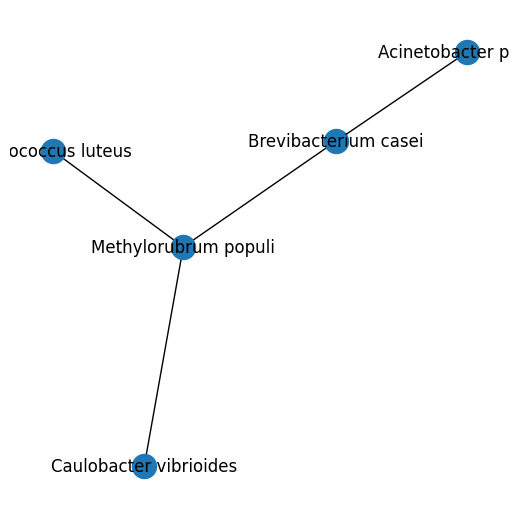

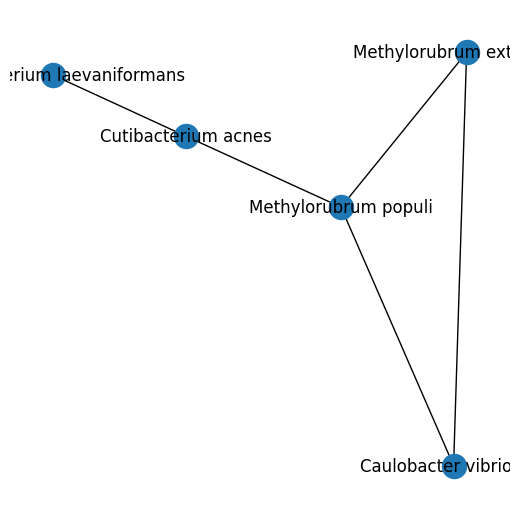

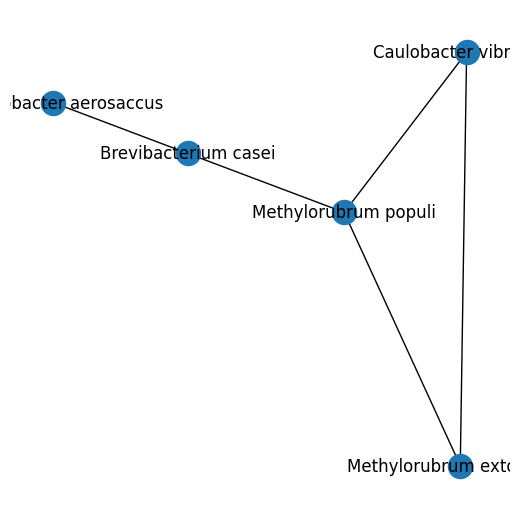

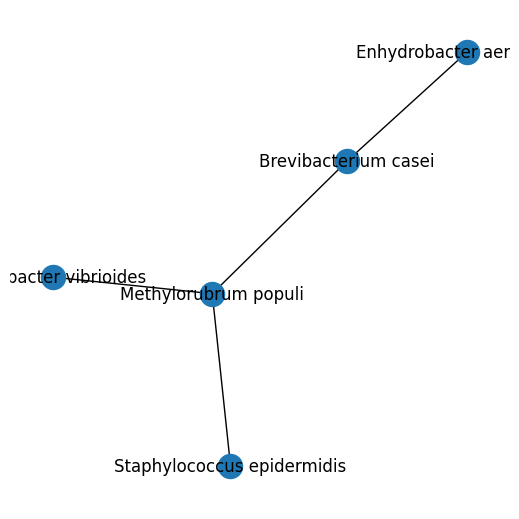

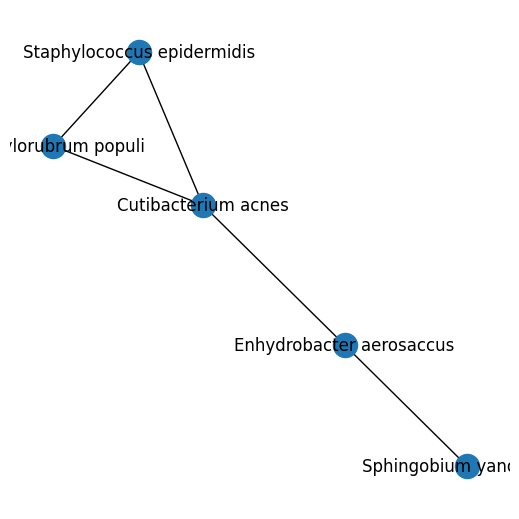

In [52]:
# Set a seed for reproducibility
random.seed(42)

# Generate random subgraphs
def generate_random_subgraphs(graph, env="Hospital", num_nodes=5, num_subgraphs=10, sample_info=sample_info):
    community_df = {"community id": [], "organism id": []}
    communities_generated = 0

    while communities_generated < num_subgraphs:
        node_list = list(graph.nodes())
        nodes = random.sample(node_list, num_nodes)  
        subgraph = graph.subgraph(nodes)  

        if nx.is_connected(subgraph):  
            community_id = f"{env}_{num_nodes}_{num_subgraphs}_{communities_generated+1}" 
            organism_ids = list(subgraph.nodes())
            sample_subset = sample_info[env].loc[sample_info[env].index.isin(organism_ids)]

            if (sample_subset != 0).all().sum() > 0:
                for org_id in organism_ids:
                    community_df["community id"].append(community_id)
                    community_df["organism id"].append(org_id)

                communities_generated += 1
                
                # Plot the subgraph
                #figure = plt.figure(figsize=(5, 5))
                #nx.draw(subgraph, with_labels=True)

    return pd.DataFrame(community_df)


In [122]:
model_files = glob.glob(model_path + '*.xml')
minimal_media = {}

for env in environments:
    media = []
    organisms = nodes_info[env]
    organisms = sorted([org.replace(" ", "_") for org in organisms])
    models = [item for item in model_files if any(organism in item for organism in organisms)]
    for model in models:
        model_obj = cobra.io.read_sbml_model(model)
        media += list(minimal_medium(model_obj, 0.1, minimize_components=True).keys())

    media = sorted(list(set([element[3:] for element in media])))
    minimal_media[env] = media

minimal_media

Adding exchange reaction EX_13ppd_e with default bounds for boundary metabolite: 13ppd_e.
Adding exchange reaction EX_14glucan_e with default bounds for boundary metabolite: 14glucan_e.
Adding exchange reaction EX_26dap__M_e with default bounds for boundary metabolite: 26dap__M_e.
Adding exchange reaction EX_2mpa_e with default bounds for boundary metabolite: 2mpa_e.
Adding exchange reaction EX_3amp_e with default bounds for boundary metabolite: 3amp_e.
Adding exchange reaction EX_3cmp_e with default bounds for boundary metabolite: 3cmp_e.
Adding exchange reaction EX_3gmp_e with default bounds for boundary metabolite: 3gmp_e.
Adding exchange reaction EX_3mba_e with default bounds for boundary metabolite: 3mba_e.
Adding exchange reaction EX_3ump_e with default bounds for boundary metabolite: 3ump_e.
Adding exchange reaction EX_4abut_e with default bounds for boundary metabolite: 4abut_e.
Adding exchange reaction EX_4hpro_LT_e with default bounds for boundary metabolite: 4hpro_LT_e.
Addi

{'Hospital': ['23camp_e',
  '26dap__M_e',
  '2ameph_e',
  '2pglyc_e',
  '3amp_e',
  '3cmp_e',
  '3gmp_e',
  '3mb_e',
  '3ump_e',
  '4abzglu_e',
  '4ahmmp_e',
  '4hphac_e',
  '5mcsn_e',
  'LalaDgluMdapDala_e',
  'LalaDgluMdap_e',
  'Lcyst_e',
  'R_3httdca_e',
  'acac_e',
  'acgam1p_e',
  'acgam_e',
  'acglu_e',
  'acmana_e',
  'acnam_e',
  'ala_B_e',
  'ala_L_glu__L_e',
  'ala_L_thr__L_e',
  'ala__D_e',
  'ala_gln_e',
  'ala_his_e',
  'ala_leu_e',
  'alaleu_e',
  'amp_e',
  'arbt_e',
  'arg__L_e',
  'asn__L_e',
  'but_e',
  'butso3_e',
  'bz_e',
  'bzalc_e',
  'ca2_e',
  'carn_e',
  'cell6_e',
  'cgly_e',
  'ch4s_e',
  'chol_e',
  'chols_e',
  'chor_e',
  'cit_e',
  'citr__L_e',
  'cl_e',
  'cmp_e',
  'coa_e',
  'cobalt2_e',
  'csn_e',
  'cu2_e',
  'cu_e',
  'cys__L_e',
  'dag181d9_e',
  'ddca_e',
  'dmso2_e',
  'dtmp_e',
  'dxyl_e',
  'f6p_e',
  'fcmcbtt_e',
  'fe2_e',
  'fe3_e',
  'fe3dcit_e',
  'fe3dhbzs3_e',
  'fe3pyovd_kt_e',
  'feenter_e',
  'fol_e',
  'fru_e',
  'g3pc_e',
  'g3pe

In [8]:
pip install pyvis

  Using cached pyvis-0.3.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached jsonpickle-3.0.4-py3-none-any.whl.metadata (2.6 kB)
Using cached pyvis-0.3.2-py3-none-any.whl (756 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 1.4 MB/s eta 0:00:00 0:00:01
Using cached jsonpickle-3.0.4-py3-none-any.whl (39 kB)
Note: you may need to restart the kernel to use updated packages.


In [10]:
from metquest import calculate_pairwiseMSI


path = r'/mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/Models'
sd_file = r'C:\Users\dines\PycharmProjects\share_code\msi\example\seed_metabolites_file.txt'
calculate_pairwiseMSI(path, sd_file)

Filenames ['Abiotrophia_defectiva.xml', 'Achromobacter_xylosoxidans.xml', 'Acinetobacter_baumannii.xml', 'Acinetobacter_johnsonii.xml', 'Acinetobacter_junii.xml', 'Acinetobacter_lwoffii.xml', 'Acinetobacter_parvus.xml', 'Acinetobacter_schindleri.xml', 'Acinetobacter_ursingii.xml', 'Actinomyces_oris.xml', 'Actinomyces_viscosus.xml', 'Aerococcus_viridans.xml', 'Bacteroides_thetaiotaomicron.xml', 'Bacteroides_uniformis.xml', 'Bifidobacterium_adolescentis.xml', 'Bifidobacterium_breve.xml', 'Bifidobacterium_longum.xml', 'Brachybacterium_muris.xml', 'Brachybacterium_paraconglomeratum.xml', 'Brevibacterium_casei.xml', 'Brevibacterium_ravenspurgense.xml', 'Brevundimonas_diminuta.xml', 'Caulobacter_vibrioides.xml', 'Chroococcidiopsis_thermalis.xml', 'Collinsella_aerofaciens.xml', 'Corynebacterium_accolens.xml', 'Corynebacterium_durum.xml', 'Corynebacterium_glucuronolyticum.xml', 'Corynebacterium_jeikeium.xml', 'Corynebacterium_kroppenstedtii.xml', 'Corynebacterium_matruchotii.xml', 'Corynebacte

Adding exchange reaction EX_13ppd_e with default bounds for boundary metabolite: 13ppd_e.
Adding exchange reaction EX_14glucan_e with default bounds for boundary metabolite: 14glucan_e.
Adding exchange reaction EX_26dap__M_e with default bounds for boundary metabolite: 26dap__M_e.
Adding exchange reaction EX_2mpa_e with default bounds for boundary metabolite: 2mpa_e.
Adding exchange reaction EX_3amp_e with default bounds for boundary metabolite: 3amp_e.
Adding exchange reaction EX_3cmp_e with default bounds for boundary metabolite: 3cmp_e.
Adding exchange reaction EX_3gmp_e with default bounds for boundary metabolite: 3gmp_e.
Adding exchange reaction EX_3mba_e with default bounds for boundary metabolite: 3mba_e.
Adding exchange reaction EX_3ump_e with default bounds for boundary metabolite: 3ump_e.
Adding exchange reaction EX_4abut_e with default bounds for boundary metabolite: 4abut_e.
Adding exchange reaction EX_4hpro_LT_e with default bounds for boundary metabolite: 4hpro_LT_e.
Addi

KeyboardInterrupt: 